In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer, precision_score, recall_score
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import shap

In [3]:
data = pd.read_csv('../data/LLCP_agg_cleaned.csv')

In [4]:
data['CVDCRHD4'].value_counts()

0.0    2006774
1.0     120430
Name: CVDCRHD4, dtype: int64

In [5]:
std_scaler = StandardScaler()
X = data.drop('CVDCRHD4', axis=1)
y = data['CVDCRHD4']
print(X.columns, X.shape)

X = std_scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Index(['GenHealth', 'ASTHMA3', 'EXERANY2', 'CHCSCNCR', '_BMI5CAT', '_SMOKER3',
       'DRNKANY5', '_AGEG5YR', 'Race_1.0', 'Race_2.0', 'Race_3.0', 'Race_4.0',
       'Race_5.0', 'Race_6.0', 'Kidney', 'Bronchitis', 'Depression',
       'Diabetes', 'Sex', 'Heart Attack', 'Cholesterol', 'Stroke',
       'Told Cholesterol High', 'Arthritis'],
      dtype='object') (2127204, 24)
(1701763, 24) (425441, 24) (1701763,) (425441,)


In [6]:
counts = y_train.value_counts()
print(counts)

0.0    1605519
1.0      96244
Name: CVDCRHD4, dtype: int64


In [30]:
# Use cross validation to find the best parameters for XGBoost

def custom_scorer(y_true, y_pred, minority_class=1):
    recall = recall_score(y_true, y_pred, pos_label=minority_class)
    precision = precision_score(y_true, y_pred, pos_label=minority_class)
    return 0.75 * recall + 0.25 * precision

ratio = counts[0] / counts[1]
params_grid = {
    'scale_pos_weight': [1, ratio / 2, ratio, 5 * ratio, 10 * ratio],
    # 'colsample_bytree': [0.8, 1],
    # 'colsample_bylevel': [0.8, 1],
    # 'colsample_bynode': [0.8, 1],
}
score_func = make_scorer(custom_scorer, greater_is_better=True)

vanilla_xgb = xgb.XGBClassifier(random_state=42, eval_metric='aucpr')
grid_search = GridSearchCV(vanilla_xgb, params_grid, scoring=score_func, cv=3, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END ................scale_pos_weight=1;, score=0.359 total time= 1.5min
[CV 2/3] END ................scale_pos_weight=1;, score=0.361 total time= 1.5min
[CV 3/3] END ................scale_pos_weight=1;, score=0.360 total time= 1.5min
[CV 1/3] END scale_pos_weight=8.340878392419267;, score=0.578 total time= 1.5min
[CV 2/3] END scale_pos_weight=8.340878392419267;, score=0.577 total time= 1.5min
[CV 3/3] END scale_pos_weight=8.340878392419267;, score=0.577 total time= 1.5min
[CV 1/3] END scale_pos_weight=16.681756784838534;, score=0.658 total time= 1.5min
[CV 2/3] END scale_pos_weight=16.681756784838534;, score=0.655 total time= 1.5min
[CV 3/3] END scale_pos_weight=16.681756784838534;, score=0.657 total time= 1.5min
[CV 1/3] END scale_pos_weight=83.40878392419268;, score=0.746 total time= 1.5min
[CV 2/3] END scale_pos_weight=83.40878392419268;, score=0.744 total time= 1.5min
[CV 3/3] END scale_pos_weight=83.4087839241926

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='aucpr', gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'scale_pos_weight': [1, 8.340878392419267,
                                              16.681756784838534,
                                              83.40878392419268,
                                              166.81756784838535]},
             scoring=make_scorer(custom_scorer), verbose=3)

In [31]:
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

{'scale_pos_weight': 166.81756784838535}
0.7543774110479736
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)


In [32]:
# Train the model with the best parameters
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='aucpr', **grid_search.best_params_)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [33]:
y_pred = xgb_model.predict(X_test)

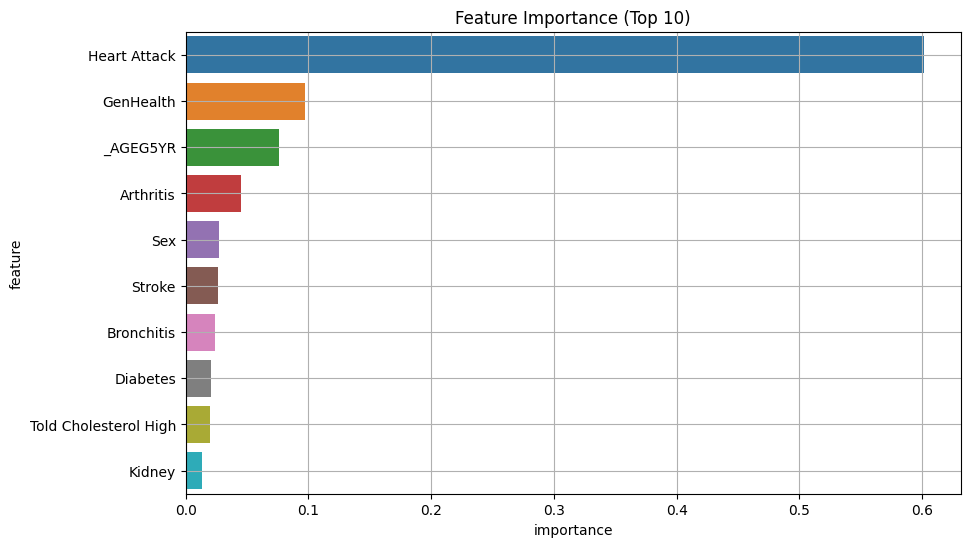

In [45]:
# feature importance (top 10)
feature_cols = data.drop(['CVDCRHD4'], axis=1).columns
feature_importance = pd.DataFrame({'feature': feature_cols, 'importance': xgb_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
# plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.iloc[:10, :])
plt.title('Feature Importance (Top 10)')
plt.grid()
plt.show()

In [46]:
# use SHAP to explain model using samples from test set
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


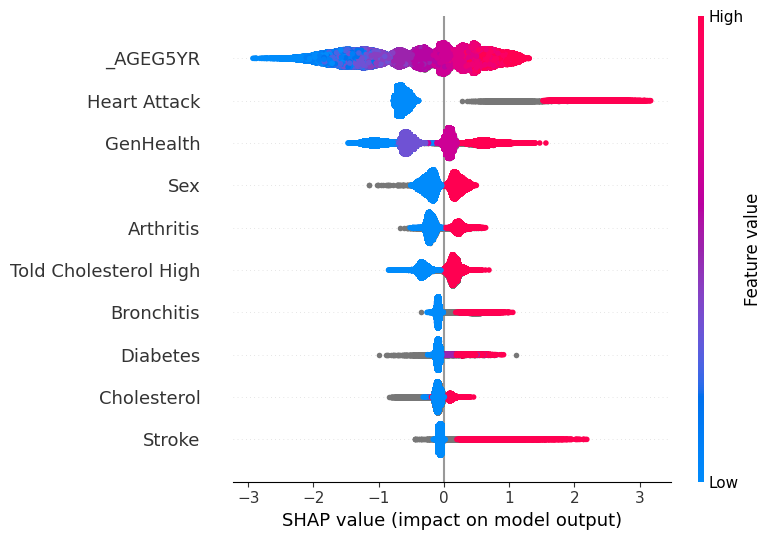

In [49]:
shap.summary_plot(shap_values, X_test, feature_names=feature_cols, max_display=10)

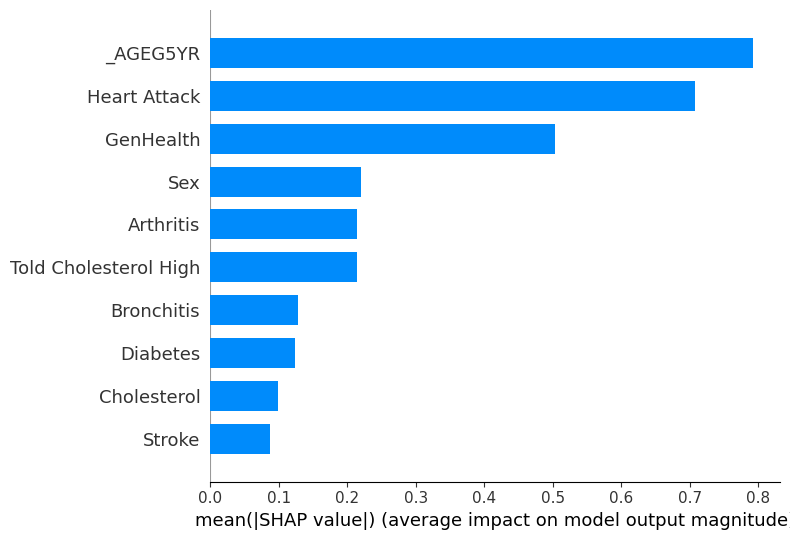

In [50]:
shap.summary_plot(shap_values, X_test, feature_names=feature_cols, plot_type='bar', max_display=10)

In [ ]:
preds = xgb_model.predict(X_test)
print(accuracy_score(y_test, preds))
print(classification_report(y_test, preds))

0.810746966089305
              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89    401255
         1.0       0.21      0.82      0.33     24186

    accuracy                           0.81    425441
   macro avg       0.60      0.81      0.61    425441
weighted avg       0.94      0.81      0.86    425441



In [ ]:
# save model and scaler
pickle.dump(std_scaler, open('../models/std_scaler.pkl', 'wb'))
pickle.dump(xgb_model, open('../models/xgb_model.pkl', 'wb'))